In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

Najpierw wczytujemy plik

In [2]:
df = pd.read_csv("./titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Sprawdzamy wymiarowość ramki i informacje o zbiorze danych

In [3]:
print(df.shape)
print("")
df.info()

(418, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


Wizualizujemy dane zanim przejdziemy do ich czyszczenia

/var/folders/ff/xn8h_gc16ll2zb2qh6_dzntm0000gn/T/ipykernel_94023/3971387956.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Fare"],color="g")
/var/folders/ff/xn8h_gc16ll2zb2qh6_dzntm0000gn/T/ipykernel_94023/3971387956.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Age"],color="

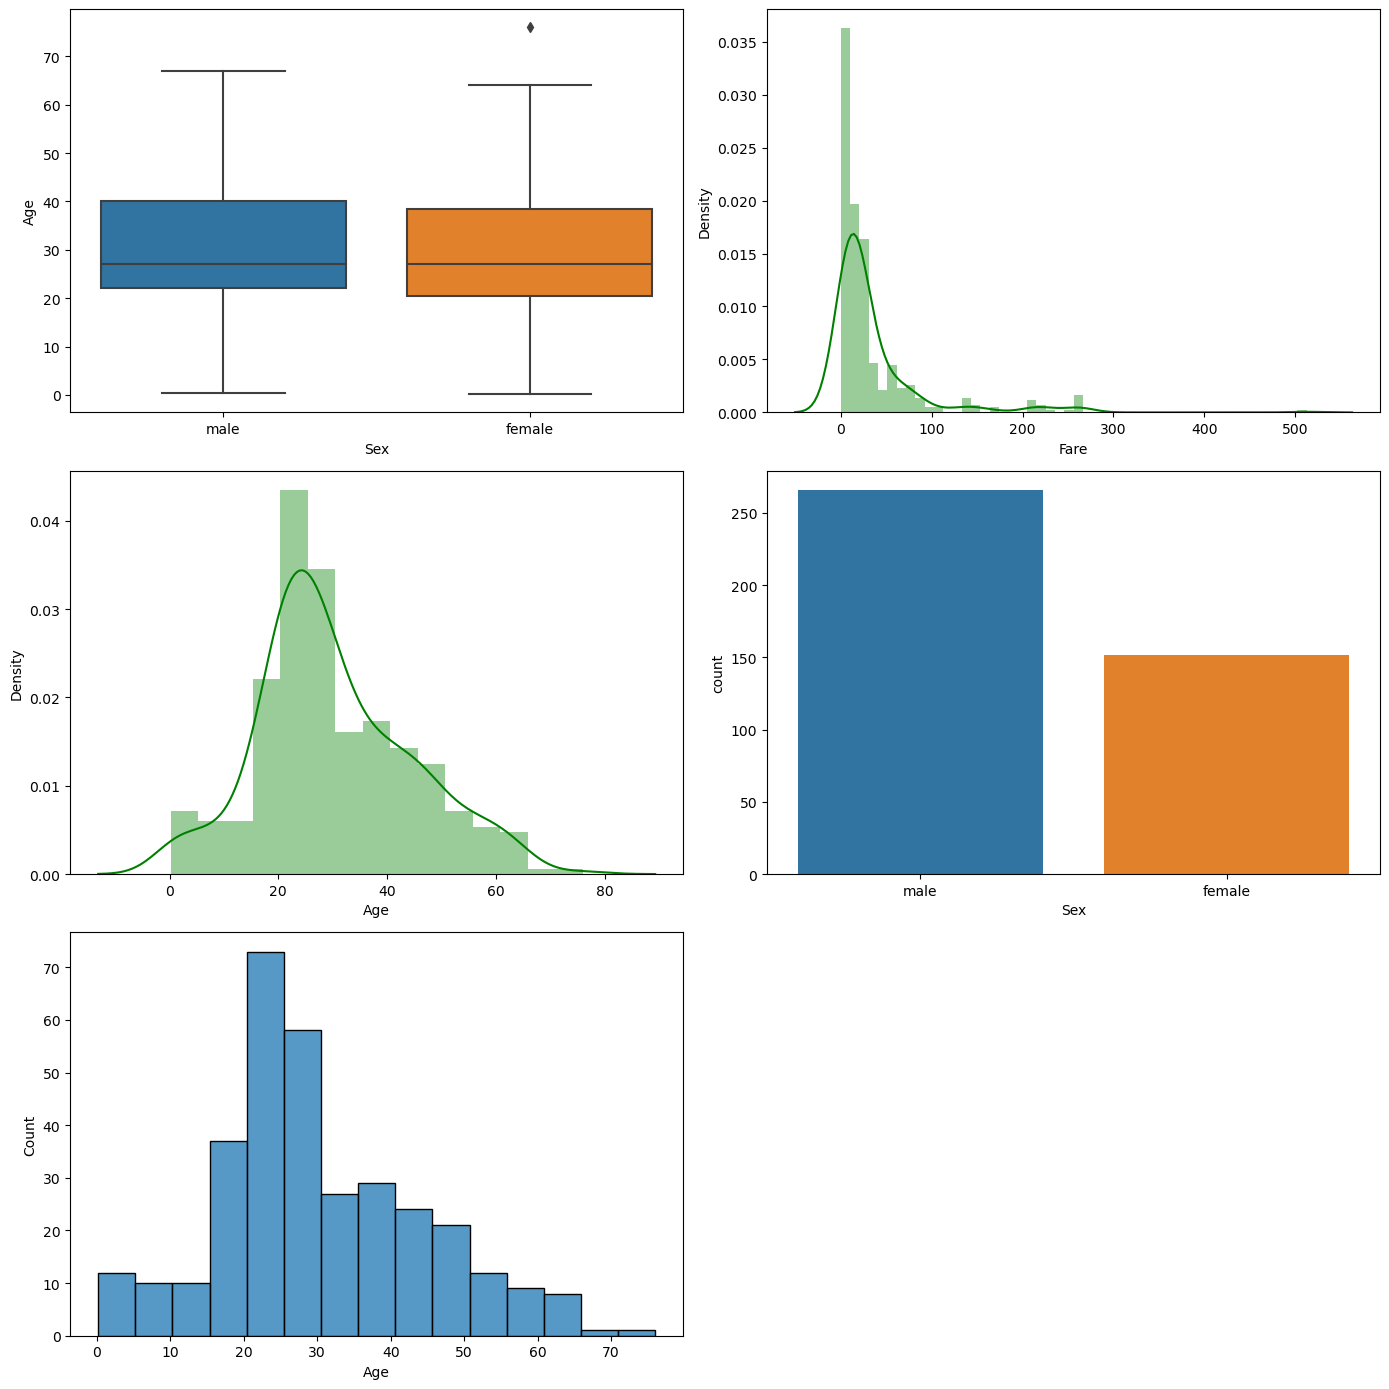

In [4]:
# data visualisation before cleaning data 

plt.figure(figsize=(14,14))
plt.subplot(3,2,1)
sns.boxplot(x='Sex', y = 'Age',data= df)
# "male": 1, "female": 0

plt.subplot(3,2,2)
sns.distplot(df["Fare"],color="g")

plt.subplot(3,2,3)
sns.distplot(df["Age"],color="g")

plt.subplot(3,2,4)
sns.countplot(x="Sex", data=df)

plt.subplot(3,2,5)
sns.histplot(df["Age"])


plt.tight_layout()
plt.show()

Wykonujemy redukcję wymiaru zbioru danych poprzez usunięcie zbędnych kolumn

In [5]:
try:
    df.drop(columns=["PassengerId", "Name", "Embarked", "Cabin", "Ticket"],inplace=True)
except KeyError:
    pass
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,34.5,0,0,7.8292
1,1,3,female,47.0,1,0,7.0000
2,0,2,male,62.0,0,0,9.6875
3,0,3,male,27.0,0,0,8.6625
4,1,3,female,22.0,1,1,12.2875


Sprawdzamy, czy w jakiejś kolumnie nie ma brakujących wartości

In [6]:
df.isna().sum()

Survived     0
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
dtype: int64

In [7]:
df.isna().sum() > 0

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare         True
dtype: bool

Zastępujemy brakujace wartości medianą z wartości z danej kolumny

In [8]:
tmp = df.select_dtypes(include=[np.number])
filter = ~tmp.isna()
tmp = tmp.where(filter, tmp.median(), axis=1)
df[tmp.columns] = tmp[tmp.columns]
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,34.5,0,0,7.8292
1,1,3,female,47.0,1,0,7.0000
2,0,2,male,62.0,0,0,9.6875
3,0,3,male,27.0,0,0,8.6625
4,1,3,female,22.0,1,1,12.2875
...,...,...,...,...,...,...,...
413,0,3,male,27.0,0,0,8.0500
414,1,1,female,39.0,0,0,108.9000
415,0,3,male,38.5,0,0,7.2500
416,0,3,male,27.0,0,0,8.0500


Zmieniamy wartości tekstowe w kolumnie płeć (Sex) na wartości numeryczne. Cyfra "1" będzie oznaczać "męczyznę", a cyfra "0" kobietę. Następnie liczymy, ilu przedstawicieli danej płci jest w zbiorze danych.

In [9]:
df['Sex'] = df['Sex'].map({
                        'male': 1,
                        'female': 0,
                        1: 1,
                        0: 0
                      })

df['Sex'].value_counts()

Sex
1    266
0    152
Name: count, dtype: int64

Oto rezultat:

In [10]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,34.5,0,0,7.8292
1,1,3,0,47.0,1,0,7.0000
2,0,2,1,62.0,0,0,9.6875
3,0,3,1,27.0,0,0,8.6625
4,1,3,0,22.0,1,1,12.2875


Sprawdzamy, czy jeszcze w jakiejś kolumnie nie ma brakujących wartości

In [11]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64

Sprawdzamy, jaki typ danych mamy obecnie w danej kolumnie

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  418 non-null    int64  
 1   Pclass    418 non-null    int64  
 2   Sex       418 non-null    int64  
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Fare      418 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 23.0 KB


Sprawdzamy tendencję centralną, rozrzut i kształt zbioru danych

In [13]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.363636,2.265550,0.636364,29.599282,0.447368,0.392344,35.576535
std,0.481622,0.841838,0.481622,12.703770,0.896760,0.981429,55.850103
min,0.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,1.000000,27.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,35.750000,1.000000,0.000000,31.471875
max,1.000000,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200


Sprawdzamy wariancję zmiennych w naszym zbiorze danych

In [14]:
df.var(axis=0)

Survived       0.231960
Pclass         0.708690
Sex            0.231960
Age          161.385768
SibSp          0.804178
Parch          0.963203
Fare        3119.233971
dtype: float64

Sprawdzamy, jak wyglądają grafy po czyszczeniu danych

/var/folders/ff/xn8h_gc16ll2zb2qh6_dzntm0000gn/T/ipykernel_94023/2424999711.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Fare'],color='g')
/var/folders/ff/xn8h_gc16ll2zb2qh6_dzntm0000gn/T/ipykernel_94023/2424999711.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'],color='

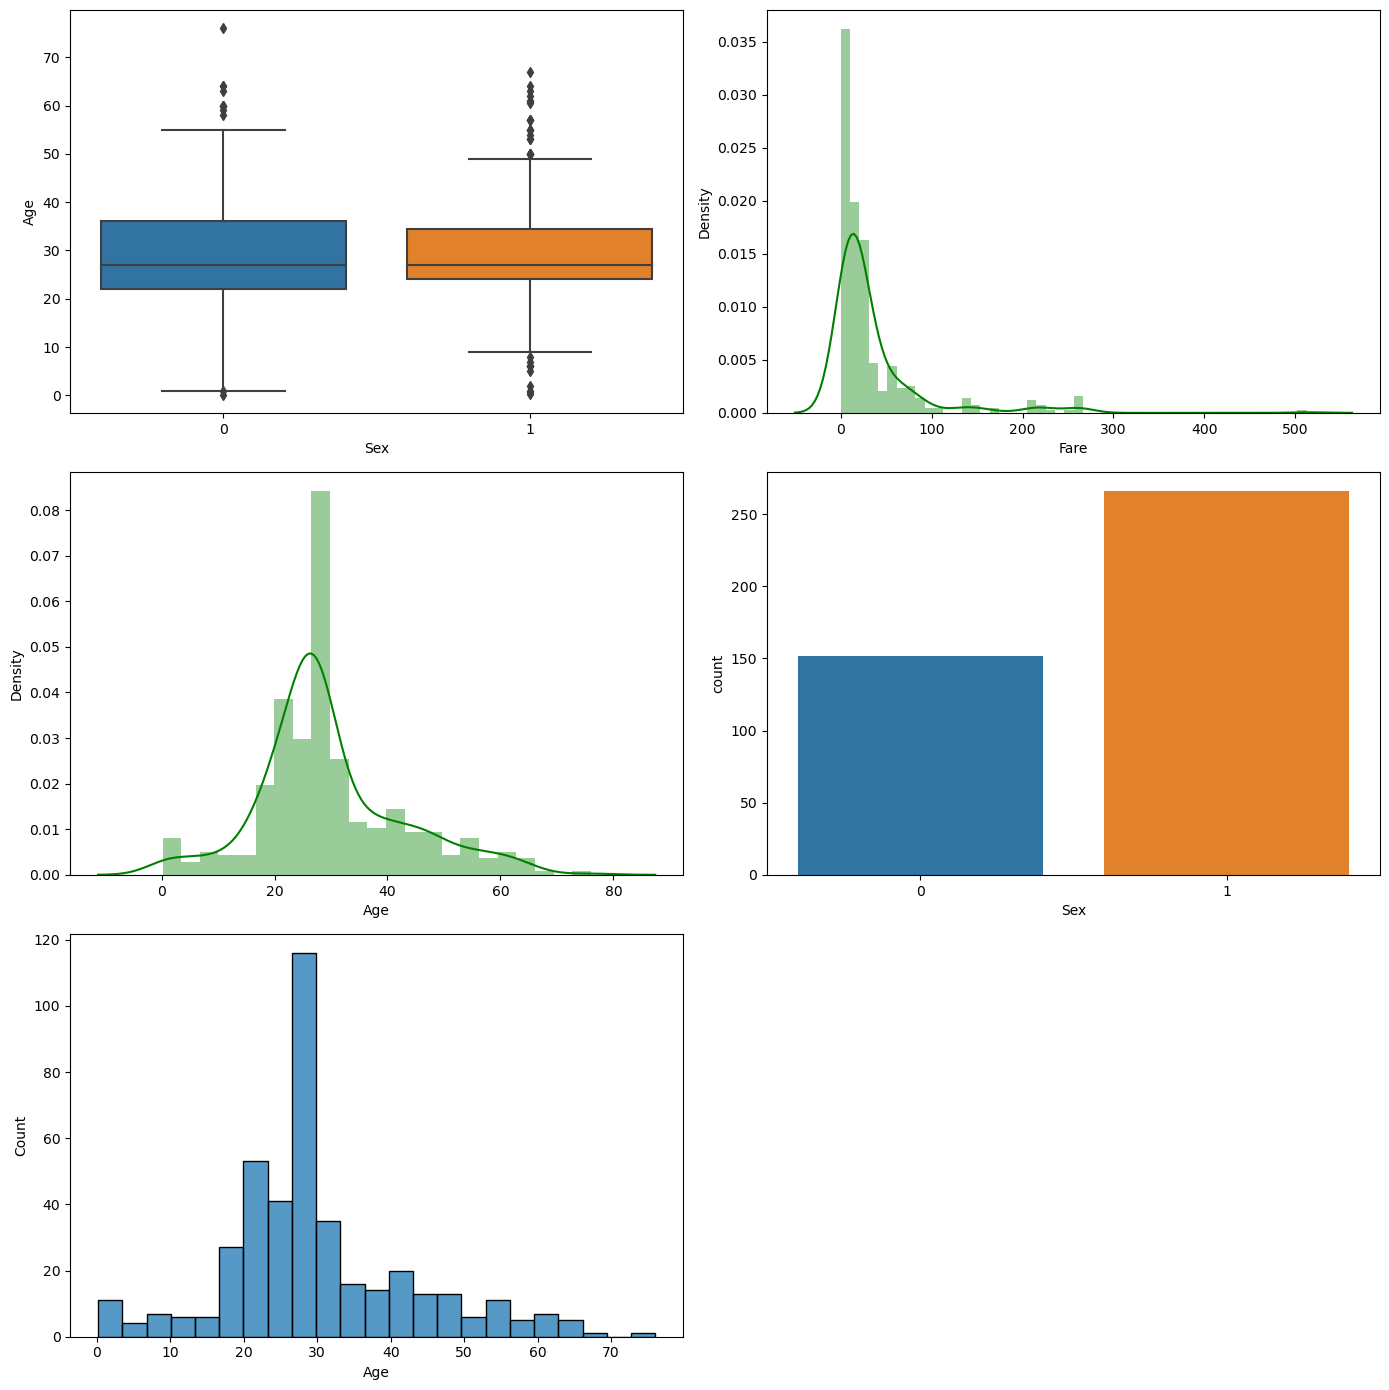

In [15]:
plt.figure(figsize=(14,14))
plt.subplot(3,2,1)
sns.boxplot(x='Sex', y = 'Age',data= df)
# 'male': 1, 'female': 0

plt.subplot(3,2,2)
sns.distplot(df['Fare'],color='g')

plt.subplot(3,2,3)
sns.distplot(df['Age'],color='g')

plt.subplot(3,2,4)
sns.countplot(x='Sex', data=df)

plt.subplot(3,2,5)
sns.histplot(df['Age'])


plt.tight_layout()
plt.show()

Sprawdzamy zaleźności pomiędzy zmiennymi: W jaki sposób przezywalność zalezała od klas rezerwacyjnych

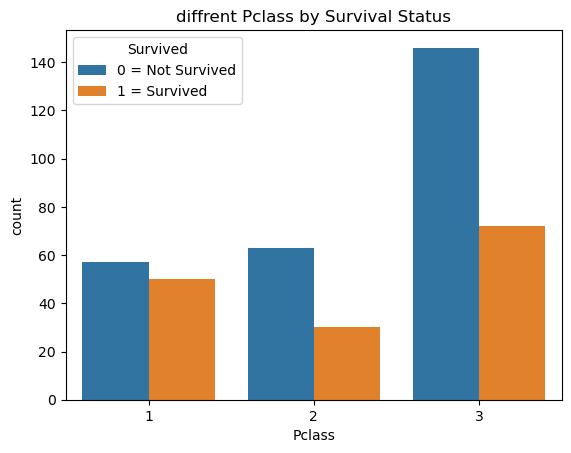

In [16]:
sns.countplot(x='Pclass',data=df,hue='Survived')
legend_labels = {0: 'Not Survived', 1: 'Survived'}
plt.legend(title='Survived', labels=[f"{key} = {value}" for key, value in legend_labels.items()])
plt.title('diffrent Pclass by Survival Status')
plt.show()

Sprawdzamy czy wiek wpływał na przeywalność pasazerów

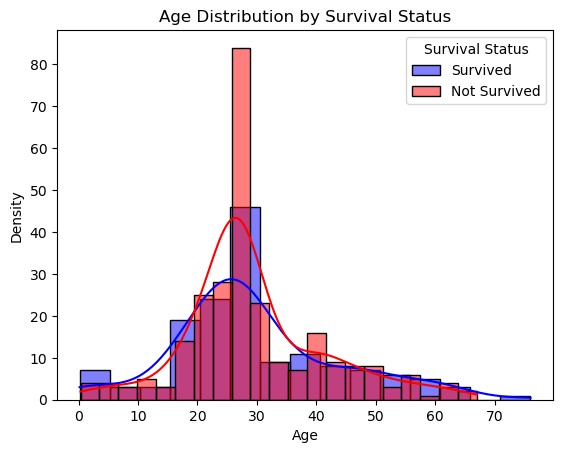

In [17]:
sns.histplot(data=df[df['Survived'] == 1], x='Age', kde=True, color='blue', label='Survived')
sns.histplot(data=df[df['Survived'] == 0], x='Age', kde=True, color='red', label='Not Survived')

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Survival Status')

plt.legend(title='Survival Status')

plt.show()

Sprawdzamy korelacje między zmiennymi

<Axes: >

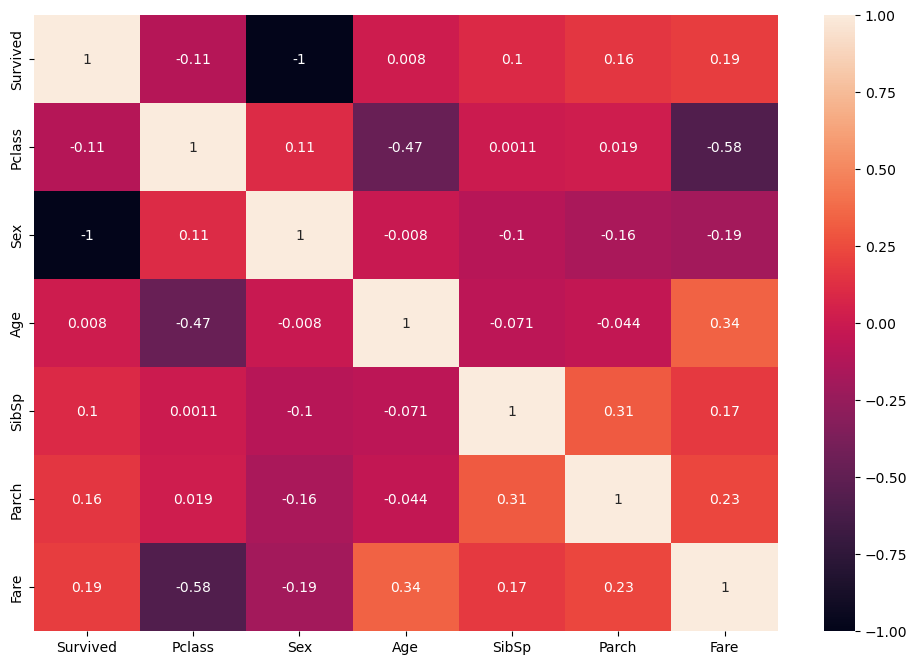

In [18]:
plt.figure(figsize=[12,8])
sns.heatmap(df.corr(),annot=True)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix
%matplotlib inline

Dzielimy nasz zbiór danych na zbiory X i Y. X to zbiór wszystkich kolumn oprócz "Survived", aa Y to kolumna (wektor) zawierający wartości "Survived". Celem modelowania będzie sprawdzenie teoretycznej przezywalności pasazera statku Titanic na podstawie pozostałych zmiennych. Zbiory zostały podzielone dodatkowo na treningowy (`X_train` i `Y_train`) i walidacyjny (`X_test` i `Y_test`) w celu poprawnego wytrenowania poszczególnych algorytmów.

In [44]:
x = df.drop(['Survived'],axis=1)
y = df['Survived']


X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.25, random_state = 45)

Tworzymy raport danych. Z raportu mozemy wywnioskować, ze zachodzi duza korelacja między zmienną opisującą osoby które przezyły oraz zmienną opisującą płeć pasazera.

In [47]:
import ydata_profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Titanic Dataset", html={'style': {'full_width': True}}, sort=None)

In [48]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Oszacowujemy, które z podanych modeli najlepiej modelują nasz zbiór danych

In [150]:
models = {'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Support Vector Machine': SVC(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'K-Nearest Neighbors': KNeighborsClassifier(),
          'Neural Network': MLPClassifier(max_iter=1000)
          }
accuracy_results = {}  # to keep all results

Najpierw oszacowujemy kazdy z modeli osobno

In [194]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
accuracy_results["Logistic Regression"] = accuracy
print(f"Logistic Regression - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Logistic Regression - Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        39

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84




In [153]:
decfor = DecisionTreeClassifier()
decfor.fit(X_train, Y_train)
Y_pred = decfor.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
accuracy_results["Decision Tree"] = accuracy
print(f"Decision Tree - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Decision Tree - Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        39

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84




In [159]:
rand = RandomForestClassifier()
rand.fit(X_train, Y_train)
Y_pred = rand.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"Random Forest - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Random Forest - Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        39

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84




In [160]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"LSupport Vector Machine - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

LSupport Vector Machine - Accuracy: 0.57
Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        45
           1       1.00      0.08      0.14        39

    accuracy                           0.57        84
   macro avg       0.78      0.54      0.43        84
weighted avg       0.76      0.57      0.45        84




In [30]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, Y_train)
Y_pred = gbc.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"Gradient Boosting - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Gradient Boosting - Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        43

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105




In [31]:
knc = KNeighborsClassifier()
knc.fit(X_train, Y_train)
Y_pred = knc.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"K-Nearest Neighbors - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

K-Nearest Neighbors - Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75        62
           1       0.65      0.56      0.60        43

    accuracy                           0.70       105
   macro avg       0.68      0.67      0.68       105
weighted avg       0.69      0.70      0.69       105




In [32]:
mlp = MLPClassifier(max_iter=130)
mlp.fit(X_train, Y_train)
Y_pred = mlp.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)  # Compute classification report
print(f"Neural Network - Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}\n")

Neural Network - Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        62
           1       0.96      1.00      0.98        43

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105




/Users/katarzynaiwaszkiewicz/anaconda3/envs/MaszLen/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (130) reached and the optimization hasn't converged yet.
  warnings.warn(


Na podstawie stworzonej listy mozemy lepiej zobaczyć, ze az pięć modeli ma 100% dokładności: Drzewa Decyzyjne, Random Forest, XGBoost, Regresja logistyczna oraz Ridge

In [154]:
df_lista = pd.DataFrame([accuracy_results])
df_lista = df_lista.transpose()
df_lista = df_lista.rename(columns={0:'Score'}).sort_values(by='Score',ascending=False)

In [155]:
df_lista.style.set_properties(**{'background-color': 'white',
                                    'color': 'red',
                                    'border': '0.5px  solid black'})

,Score
Logistic Regression,1.000000
Decision Tree,1.000000


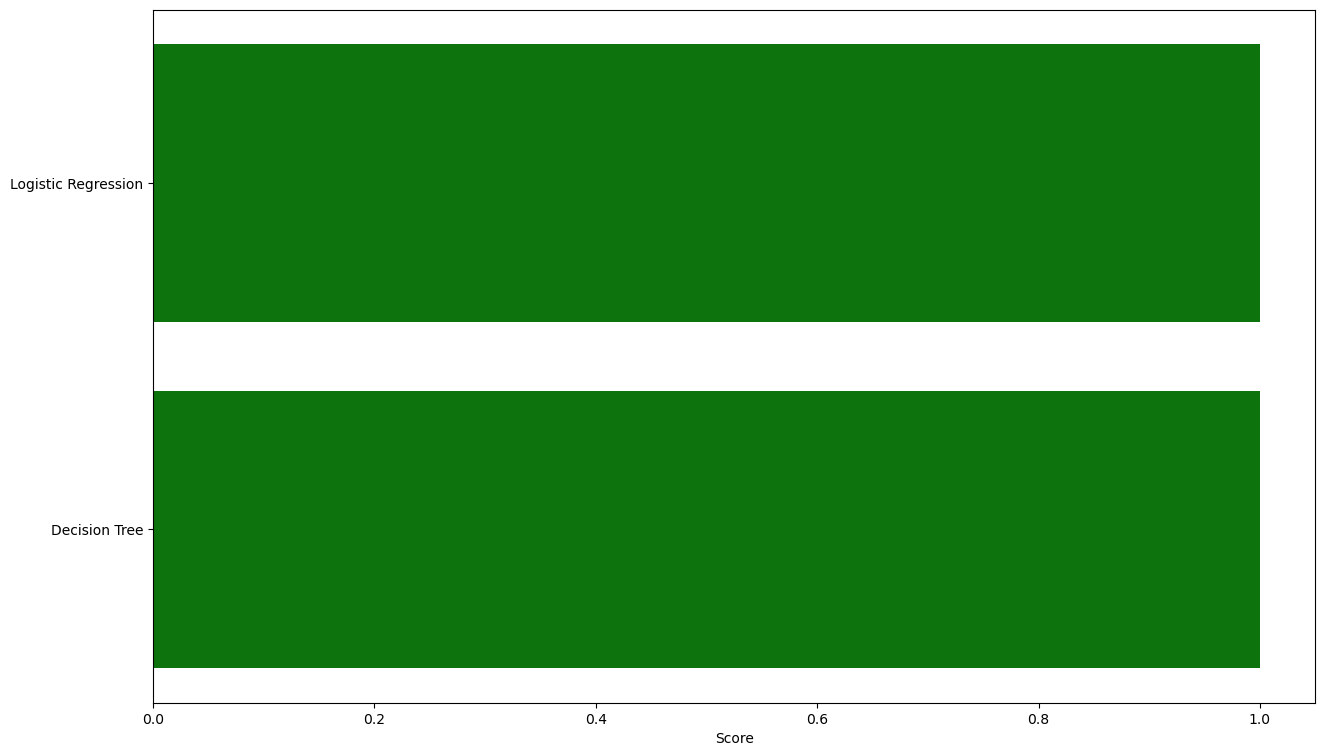

In [156]:
fig = plt.figure(figsize=(15,9))

ax = sns.barplot(data=df_lista, 
                 y=df_lista.index, 
                 x='Score',
                 saturation=0.8,
                 linewidth=0.1,
                 color = 'green')

Algorytm Random Forest daje najlepszy wynik i dobrze się zapowiada, więc przetestujmy go do całego zbioru.


In [162]:
X_predict = list(rand.predict(X_test))
predicted_df = {'predicted_values': X_predict,'original_values': Y_test}
print(pd.DataFrame(predicted_df).head(10))
if np.all(predicted_df["predicted_values"] == predicted_df["original_values"]):
    print("All correct!")
else:
    print("Values are mismatched!")
print('Here O = not survived and 1 = survived')

   predicted_values  original_values
0                 0                0
1                 0                0
2                 1                1
3                 0                0
4                 1                1
5                 0                0
6                 1                1
7                 0                0
8                 0                0
9                 0                0
All correct!
Here O = not survived and 1 = survived


Prezentujemy graf oraz macierz pomyłek, by lepiej zobrazować dokładność naszego modelu

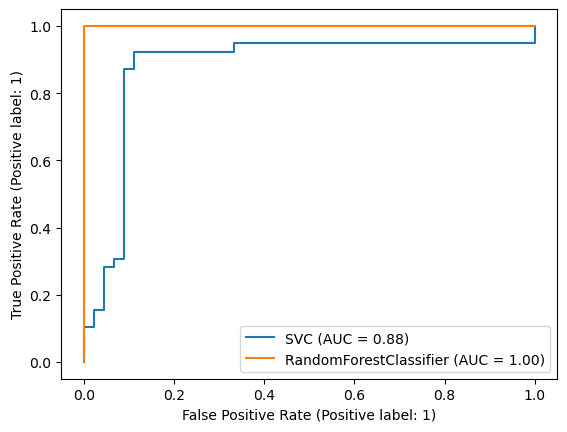

In [168]:
from sklearn.metrics import RocCurveDisplay
A = RocCurveDisplay.from_estimator(svc, X_test, Y_test)
B = RocCurveDisplay.from_estimator(rand, X_test, Y_test, ax=A.ax_)

In [178]:
predict= rand.predict(X_test)
predictA = svc.predict(X_test)

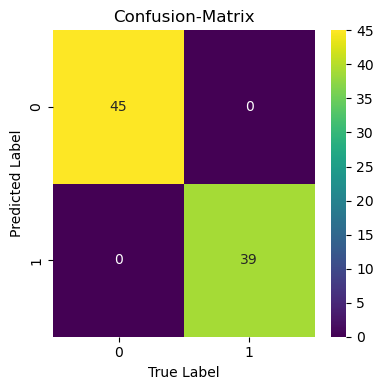

In [169]:
fig,ax = plt.subplots(figsize=(4,4))
ax= sns.heatmap(confusion_matrix(Y_test, predict),
                annot = True,
                cbar= True,
                fmt='g',
                cmap = 'viridis')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion-Matrix')
plt.tight_layout()  
plt.show()

In [179]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        39

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



Przechodzimy do optymalizowania hiperparametrów w metodzie Random Forest za pomocą biblioteki `optuna`

In [180]:
import optuna

import sklearn.datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    x, y = X_train,Y_train

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 2, 100, log=True)
    n_estimators = trial.suggest_int("n_estimators", 1,1000)    
    min_samples_split = trial.suggest_int("min_samples_split",1,5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf",1,5)
    

    rf = sklearn.ensemble.RandomForestClassifier(criterion =criterion,
            max_depth=max_depth, 
            n_estimators=n_estimators
        )

    score = cross_val_score(rf, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=101)

[I 2023-12-14 23:02:33,981] A new study created in memory with name: no-name-f6200b0a-cfc7-4c92-ba11-5af7521eddf2
[I 2023-12-14 23:02:34,160] Trial 0 finished with value: 1.0 and parameters: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 340, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.
[I 2023-12-14 23:02:34,345] Trial 1 finished with value: 1.0 and parameters: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 389, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 1.0.
[I 2023-12-14 23:02:34,483] Trial 2 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 271, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 1.0.
[I 2023-12-14 23:02:34,757] Trial 3 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 566, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.
[I 2023-12-1

Sprawdzamy i wybieramy najlepszą próbę

In [181]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 1.0
Best hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 340, 'min_samples_split': 4, 'min_samples_leaf': 3}


Przekazujemy najlepsze hiperparametry do konstruktora Random Forest Classifier

In [187]:
prediction= rand.predict(X_test)
print(prediction)

[0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1
 1 0 0 1 0 1 0 1 0 0]


In [189]:
rand2 = RandomForestClassifier(**trial.params)
rand2.fit(X_train,Y_train)
sub_pre = rand2.predict(X_test)
print(sub_pre)
print(np.array_equal(predict, sub_pre))

[0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1
 1 0 0 1 0 1 0 1 0 0]
True


W tym przykładzie optymalizacja hiperparametrów nie zmieniła wyniku

Sprawdzamy, które zmienne są najistotniejsze w naszym zbiorze danych

<Axes: >

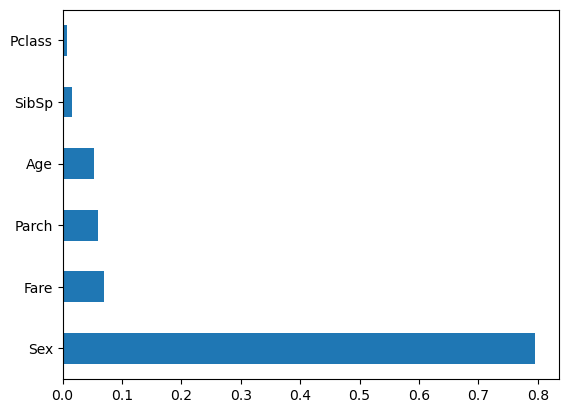

In [190]:
feat_importances = pd.Series(rand2.feature_importances_, index=df.columns)
feat_importances.nlargest(20).plot(kind='barh')

Na ponizszym wykresie widzimy, ze to, czy dana osoba przezyła katastrofę czy tez zalezalo w duzej mierze od tego, jaką miała płeć (Sex), a w drugiej kolejności od tego, ile zapłaciła za bilet (Fare)

Tutaj O = nie przezyl and 1 = przezyl


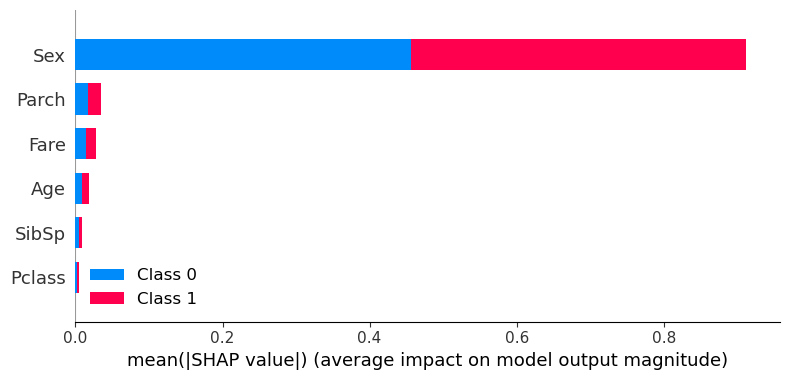

In [176]:
import shap
explainer = shap.TreeExplainer(rand)
shap_values = explainer.shap_values(X_test)
print('Tutaj O = nie przezyl and 1 = przezyl')
shap.summary_plot(shap_values, X_test)

Klasa rezerwacyjna biletów ma znaczący wpływ na wskaźnik przeżywalności pasażerów. Jest to druga najbardziej znacząca cecha po płci. Na ponizszym wykresie widzimy, że niskie wartości (niebieskie) dla Pclass, które odpowiadają klasie 1 (zamozniejsi ludzie), mają dodatni wpływ na przeżywalność ludzi, podczas gdy wyższe wartości (czerwone), które odpowiadają trzeciej klasie, mają ujemny wpływ na wskaźnik przeżywalności. Widzimy również, że płeć jest najważniejszą cechą ze wskazaniem, że bycie kobietą (płec oznaczona na grafie kolorem niebieskim) miało dodatni wpływ na wskaźnik przeżycia. Zmienna "Wiek" (Age) również pokazuje, że mniejsze wartości (niebieski) miały dodatni wpływ na przeżywalność.

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


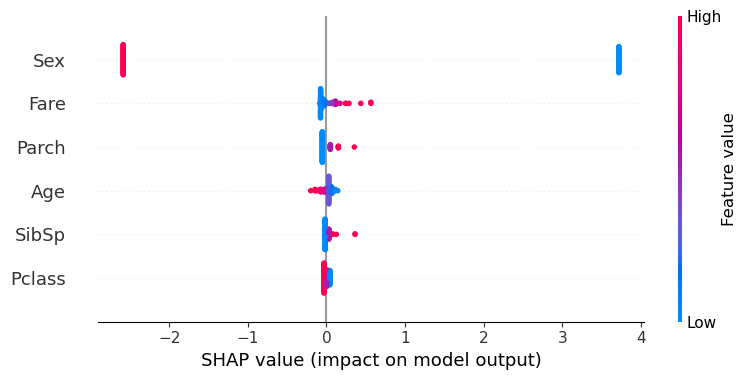

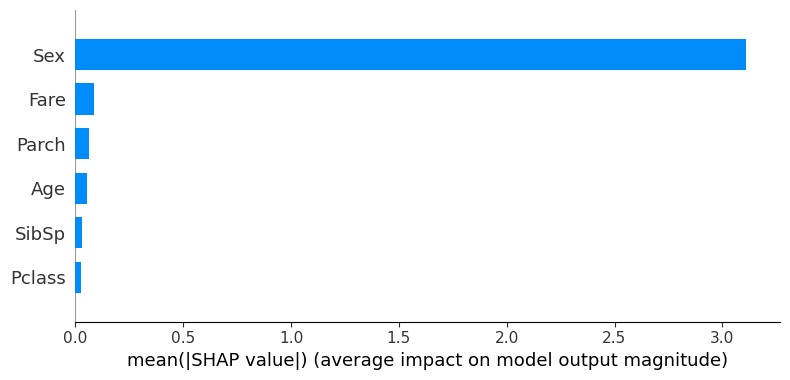

In [196]:
explainer = shap.LinearExplainer(logreg, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Ponizszy wykres pokazuje, że istnieje zależność liniowa między tym, ile ludzie zapłacili, a ich szansą na przeżycie. Im byli bogatsi, tym większe prawdopodobieństwo, że przeżyli.

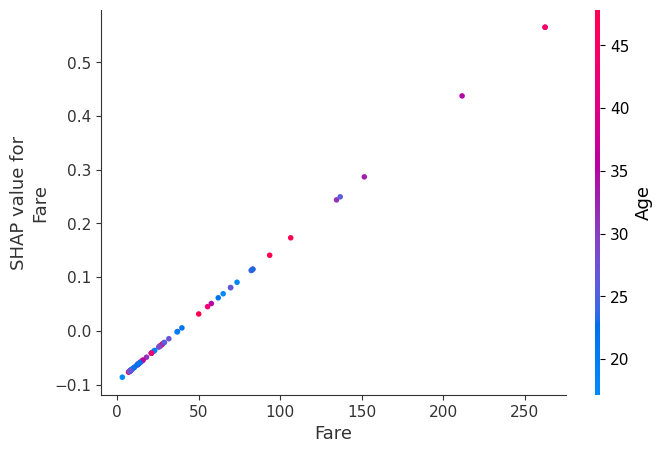

In [198]:
shap.dependence_plot("Fare", shap_values, X_test)

Ten wykres przedstawia parametry pasażera z indeksem 0, który nie przeżył. Pokazuje on, że jego "płeć" (bycie mężczyzną) i "klasa" (podrozowanie w trzeciej klasie) zmniejszały jego przezywalność. Wykres pokazuje również, że liczba rodzeństwa ("SibSp") wynosząca 0 nieznacznie zwiększyła jego szansę na przezycie.

In [199]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], link="logit")

Ponizszy wykres przedstawia sytuację kobiety, która kupiła drogi bilet. Zwiększyło to jej szansę przeżycie. Z drugiej strony to, że miała rodzeństwo i miała więcej lat, nieco zmniejszyło jej szansę na przezycie.

In [200]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], X_test.iloc[3,:], link="logit")